# Figure 2: Overview of UKBB data

## Import packages

In [25]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
# from myfunctions import transform_format 
# from myfunctions import find_best_score_for_present_var
# from myfunctions import find_best_score


In [26]:
# Lists of colors for plots
c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue0 = '#31bdb2'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple0 = '#6c31bd'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'
# yellow = '#ffffd4'

In [27]:
# set up plotting parameters 
axisfont=11
titlefont=20
subtitlefont = 15
axislabelfont=12
legendfont = 11
tpfont = 12
plt.rcParams.update({'font.sans-serif':'Arial'})

In [28]:
# get current date 
timestr = time.strftime("%Y%m%d") 

In [29]:
# do not print warnings (can be run if you don't want warnings to be printed)
import warnings
warnings.filterwarnings("ignore")

## Import UKBB data

In [30]:

# Import all the data (all calls: include singletons and higher read numbers, for all changes at a position affected in CH)

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  

# get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# initialize an empty dictionary 
dataframes = {}

# iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# extract dataframes 
for file_name, df in dataframes.items():
    
    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign df to a variable with the file name


# concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# combine all dfs into one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])

Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [31]:

# change numerical variables to integers
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# view the data
batch_all.head(n = 5)

,sample_ID,chromosome,position,end_position,ref,alt,depth,var_depth,VAF,variant_type,...,EXON,GIVEN_REF,IMPACT,INTRON,STRAND,SYMBOL,SYMBOL_SOURCE,USED_REF,VARIANT_CLASS,batch
0,2100020,chr17,7674230,7674230,C,A,32,1,0.031250,SNV,...,7/11,C,MODERATE,-,-1.0,TP53,EntrezGene,C,SNV,batch_21_annotated_data
1,2100020,chr17,7675088,7675088,C,T,54,1,0.018519,SNV,...,5/11,C,MODERATE,-,-1.0,TP53,EntrezGene,C,SNV,batch_21_annotated_data
2,2100033,chr2,25234307,25234307,G,T,85,1,0.011765,SNV,...,23/23,G,MODERATE,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data
3,2100071,chr2,25240439,25240439,G,A,92,1,0.010870,SNV,...,19/23,G,MODERATE,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data
4,2100071,chr2,25240439,25240439,G,T,92,1,0.010870,SNV,...,19/23,G,LOW,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data


In [32]:

# Import indexes tested in each batch 

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  

# get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# initialize an empty dictionary
indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():

    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[9].split('.')[0] # remove file extension
    globals()[variable_name] = df  # assign the df to a variable with the file name


## Annotate reads with the CH variant present

In [33]:

# The data that I imported is annotated but has not been filtered to only include variants that are present in CH

# prepare the dataframe for annotation
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# subset and create new useful columns
batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt'] = batch_all['Amino_acids'].str.split('/', expand = True)[1]
batch_all['ref'] = batch_all['Amino_acids'].str.split('/', expand = True)[0]

# create column with coordinates such that you can merge annotation (on genetic variant name)
batch_all['variant_coord'] = batch_all['chromosome'].astype(str) + "_" + batch_all['end_position'].astype(str) 
batch_all['variant_coord'] = batch_all['variant_coord'].astype('category')

# create column with coordinates, gene affected and specific variant 
batch_all['variant_coord_pos'] = batch_all['variant_coord'].astype(str) +  "_" + batch_all['SYMBOL'].astype(str) + "_" + batch_all['ref'].astype(str) + "_" + batch_all['alt'].astype(str)
batch_all['variant_coord_pos'] = batch_all['variant_coord_pos'].astype('category')

# view added columns
batch_all.head(n = 5)

# NOTE: in some cases, the amino acid column only contains a single aa value
# that does NOT indicate that there was a nonsense mutation (ie STOP codon introduced)
# STOP codons ARE indicated in the dataframe with "*"

,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt,ref,variant_coord,variant_coord_pos
0,2100020,chr17,7674230,0.031250,1,32,G/C,TP53,Ggc/Tgc,batch_21_annotated_data,C,G,chr17_7674230,chr17_7674230_TP53_G_C
1,2100020,chr17,7675088,0.018519,1,54,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R,chr17_7675088,chr17_7675088_TP53_R_H
2,2100033,chr2,25234307,0.011765,1,85,P/Q,DNMT3A,cCg/cAg,batch_21_annotated_data,Q,P,chr2_25234307,chr2_25234307_DNMT3A_P_Q
3,2100071,chr2,25240439,0.010870,1,92,R/W,DNMT3A,Cgg/Tgg,batch_21_annotated_data,W,R,chr2_25240439,chr2_25240439_DNMT3A_R_W
4,2100071,chr2,25240439,0.010870,1,92,R,DNMT3A,Cgg/Agg,batch_21_annotated_data,None,R,chr2_25240439,chr2_25240439_DNMT3A_R_None


In [34]:

# import coordinate data (df created manually based on COSMIC)
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# create required columns
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref'].astype(str) + "_" + coord_gene_var['alt'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [35]:
# Annotation

# subset required columns
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples examined:', batch_all.shape[0])
print('Number of patients examined:', len(batch_all.sample_ID.unique()))
print('Number of samples with annotated variants:', batch_gene_vars.shape[0])
print('Number of patients with annotated variants:', len(batch_gene_vars.sample_ID.unique()))

batch_all_ns = batch_all[batch_all['var_depth'] >= 2] # we require at least two reads here
batch_gene_vars_ns = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars_ns['gene_var'] = batch_gene_vars_ns['gene_var'].astype('category')
batch_gene_vars_ns['gene_var'].value_counts()

gene_vars_count_ns = pd.DataFrame(batch_gene_vars_ns['gene_var'].value_counts())
gene_vars_count_ns['gene_var'] = gene_vars_count_ns.index
gene_vars_count_ns = gene_vars_count_ns.reset_index(drop=True)
gene_vars_sorted_ns = gene_vars_count_ns.sort_values(by = 'count', ascending=False)

print('Number of samples with annotated variants (>= 2 reads):', batch_gene_vars_ns.shape[0])
print('Number of patients with annotated variants (>= 2 reads):', len(batch_gene_vars_ns.sample_ID.unique()))

# NOTE: batch_gene_vars = NOT filtered by number of CH-variant-carrying reads
# NOTE: batch_gene_vars_ns = FILTERED (at least 2 reads)


Number of variants identified with annotations: 38
Number of samples examined: 76718
Number of patients examined: 52356
Number of samples with annotated variants: 40752
Number of patients with annotated variants: 33377
Number of samples with annotated variants (>= 2 reads): 2249
Number of patients with annotated variants (>= 2 reads): 2214


# Plots

## Distribution of coverage, depth of variant-carrying reads and VAF

In [68]:

import matplotlib.ticker as ticker

# define the function to generate histogram plots
def histogram_dist(col, color, xlabel, desc, name, bins = 100, lines = False, log_x = False, log_y = False):
    
    plt.figure(figsize = (6,4)) # set figure size
    sns.histplot(col, color = color, bins = bins)
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel('Frequency', fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

    # set format of the y axis
    plt.locator_params(axis='y', nbins=10) # I want to have more y label ticks on each plot 

    # scientific notation
    plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0)) 
    
    # options for the function 
    if log_x == True:

        if 'vaf' in name:
            # specify names on the x-axis labels to make them more readable
            x_axis_ticks = [np.log(1), np.log(3), np.log(10), np.log(30)]
            x_axis_names = np.round(np.exp(x_axis_ticks)).astype(int)
            plt.xticks(x_axis_ticks, x_axis_names)  

        if 'coverage' in name:
            x_axis_ticks = [np.log(10), np.log(30), np.log(100), np.log(200)]
            x_axis_names = np.round(np.exp(x_axis_ticks)).astype(int)
            plt.xticks(x_axis_ticks, x_axis_names)  

    if log_y == True:
        # change y axis to log scale
        plt.yscale('log')

    if lines == True:
        mean_value = np.mean(col)
        median_value = np.median(col)

        plt.axvline(mean_value, color='darkred', linestyle='dashed', linewidth=2, label='Mean')
        plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label='Median')
        
        plt.legend(fontsize = 11)

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/{timestr}_histogram_dist_{name}.pdf', bbox_inches='tight')


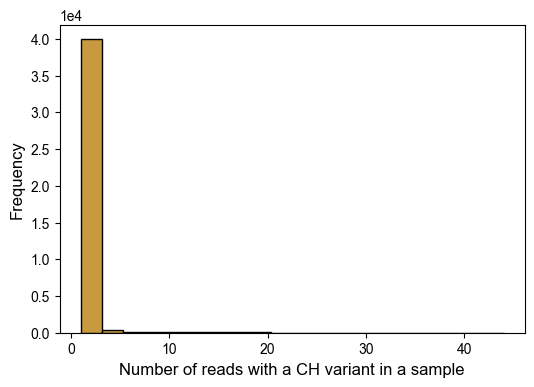

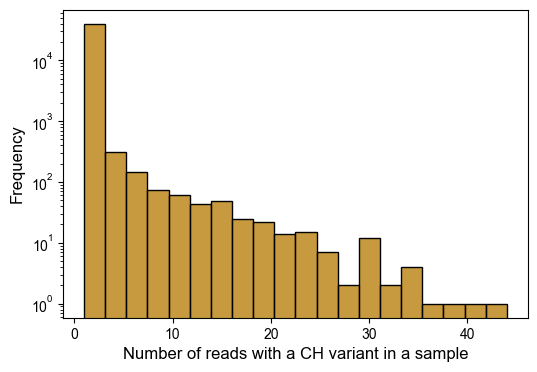

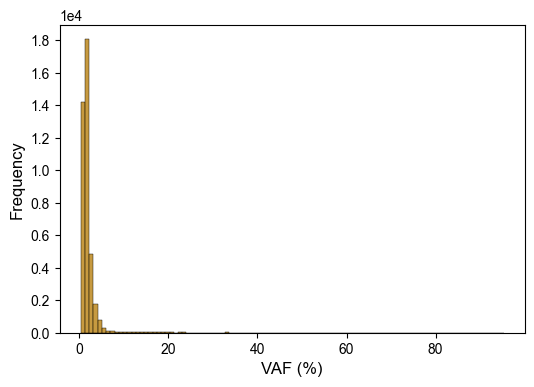

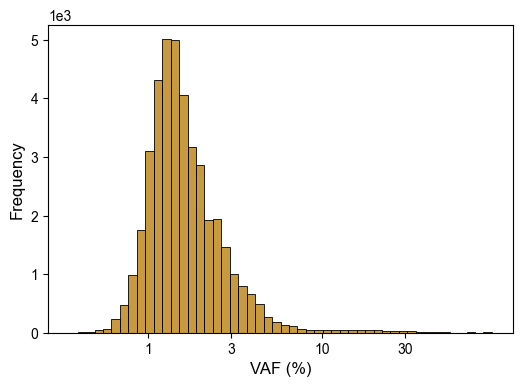

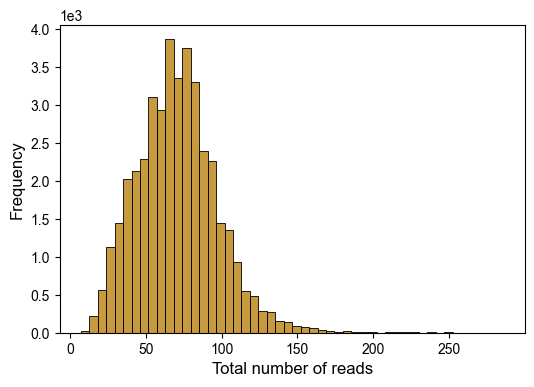

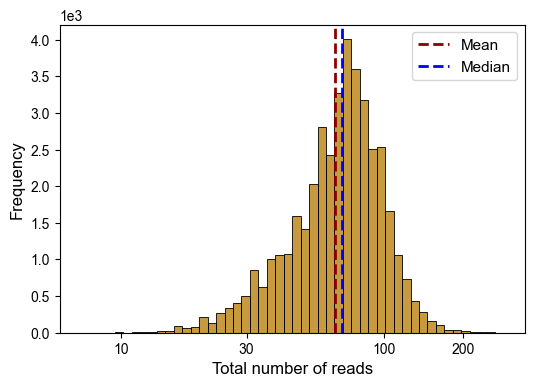

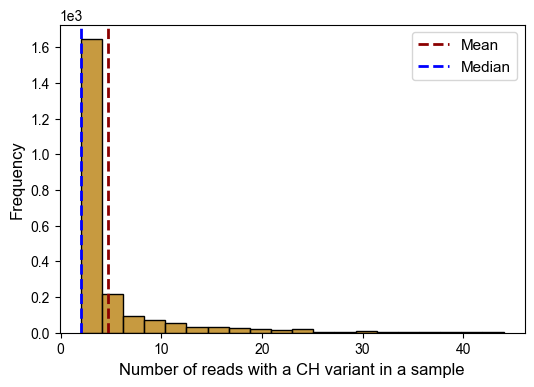

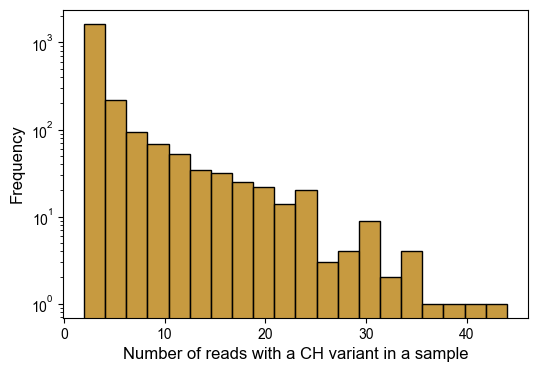

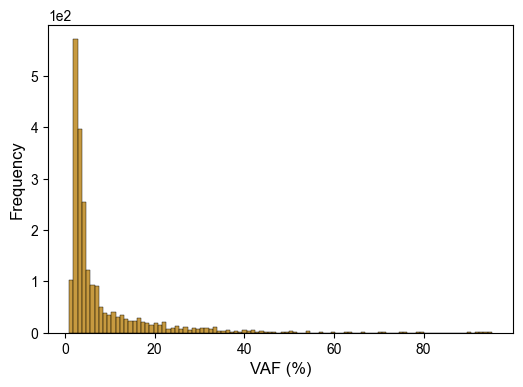

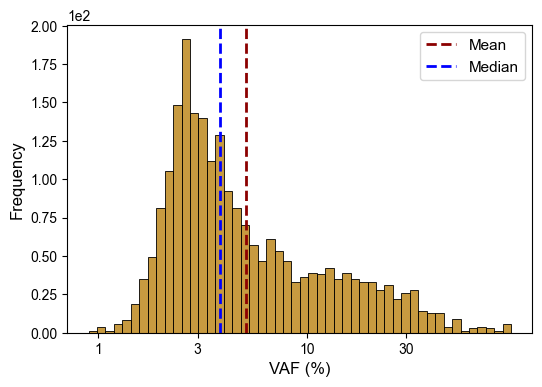

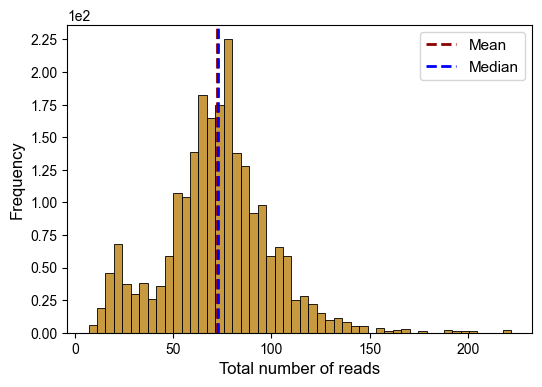

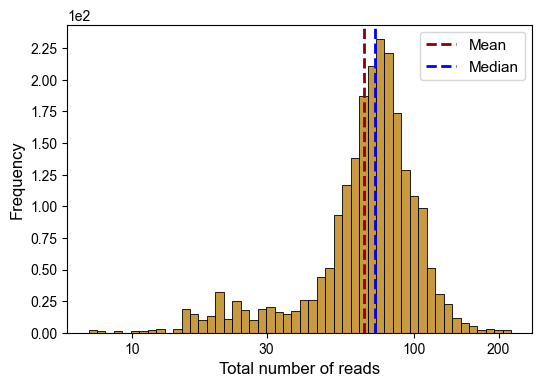

In [69]:

# plot histograms
color_hist = '#b57900'

# for n_reads >= 1 (any CH variant present)
histogram_dist(batch_gene_vars['var_depth'], color_hist, 'Number of reads with a CH variant in a sample', 'variant depth in the UKBB', 'var_depth', bins = 20)
histogram_dist(batch_gene_vars['var_depth'], color_hist, 'Number of reads with a CH variant in a sample', 'variant depth in the UKBB', 'log_var_depth', log_y = True, bins = 20)
histogram_dist(batch_gene_vars['VAF'] * 100, color_hist, 'VAF (%)', 'VAF in the UKBB', 'vaf')
histogram_dist(np.log(batch_gene_vars['VAF'] * 100), color_hist, 'VAF (%)', 'VAF in the UKBB', 'log_vaf', log_x = True, bins = 50)
histogram_dist(batch_gene_vars['depth'], color_hist, 'Total number of reads', 'coverage in the UKBB', 'coverage', bins = 50)
histogram_dist(np.log(batch_gene_vars['depth']), color_hist, 'Total number of reads', 'coverage in the UKBB', 'coverage', lines = True, log_x = True, bins = 50)

# for nr reads >= 2 
histogram_dist(batch_gene_vars_ns['var_depth'], color_hist, 'Number of reads with a CH variant in a sample', 'variant depth in the UKBB (>= 2 reads)', 'var_depth_ns', bins = 20, lines = True)
histogram_dist(batch_gene_vars_ns['var_depth'], color_hist, 'Number of reads with a CH variant in a sample', 'variant depth in the UKBB (>= 2 reads)', 'log_var_depth_ns', log_y = True, bins = 20)
histogram_dist(batch_gene_vars_ns['VAF'] * 100, color_hist, 'VAF (%)', 'VAF in the UKBB (>= 2 reads)', 'vaf_ns')
histogram_dist(np.log(batch_gene_vars_ns['VAF'] * 100), color_hist, 'VAF (%)', 'VAF in the UKBB (>= 2 reads)', 'log_vaf_ns', log_x = True, bins = 50, lines = True)
histogram_dist(batch_gene_vars_ns['depth'], color_hist, 'Total number of reads', 'coverage in the UKBB (>= 2 reads)', 'coverage_ns', bins = 50, lines = True)
histogram_dist(np.log(batch_gene_vars_ns['depth']), color_hist, 'Total number of reads', 'coverage in the UKBB (>= 2 reads)', 'coverage_ns', lines = True, log_x = True, bins = 50)


In [38]:

# create a df which contains counts across different read numbers
batch_gene_vars['var_depth'].value_counts()

num_table = pd.DataFrame(batch_gene_vars['var_depth'].value_counts())
num_table = num_table.sort_values(by = 'var_depth')

num_table['reads'] = num_table.index
num_table = num_table.reset_index(drop=True)

conditions = [
    (num_table['reads'] == 1),
    (num_table['reads'] == 2),
    (num_table['reads'] >= 3)
]
values = ['1', '2', '3 or more']

# Use numpy.select to create the new column based on conditions
num_table['read count'] = np.select(conditions, values, default='1')
num_table = num_table[['reads', 'read count', 'count']]
num_table.head(n = 5)

,reads,read count,count
0,1,1,38503
1,2,2,1129
2,3,3 or more,334
3,4,3 or more,182
4,5,3 or more,124


In [39]:
# create a df which contains counts across different read numbers
batch_gene_vars_ns['var_depth'].value_counts()

num_table_ns = pd.DataFrame(batch_gene_vars_ns['var_depth'].value_counts())
num_table_ns = num_table_ns.sort_values(by = 'var_depth')

num_table_ns['reads'] = num_table_ns.index
num_table_ns = num_table_ns.reset_index(drop=True)

conditions_ns = [
    (num_table_ns['reads'] == 2),
    (num_table_ns['reads'] == 3),
    (num_table_ns['reads'] >= 4)
]
values_ns = ['2', '3', '4 or more']

# Use numpy.select to create the new column based on conditions
num_table_ns['read count'] = np.select(conditions_ns, values_ns, default='1')
num_table_ns = num_table_ns[['reads', 'read count', 'count']]
num_table_ns.head(n = 5)

,reads,read count,count
0,2,2,1129
1,3,3,334
2,4,4 or more,182
3,5,4 or more,124
4,6,4 or more,93


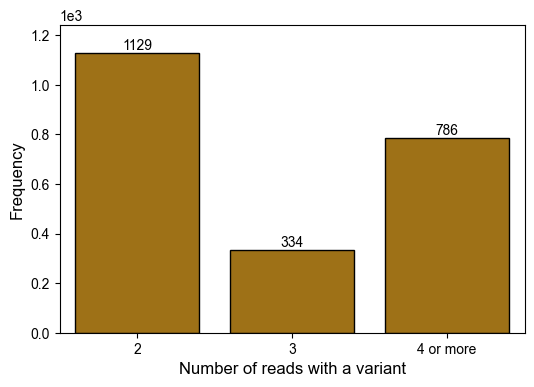

In [56]:

# let's do this only for >= 2 reads data 
plt.figure(figsize=(6,4)) # set figure size
num_table_ns['read count'] = num_table_ns['read count'].astype('category')

nums_ns = pd.DataFrame(num_table_ns.groupby('read count')['count'].sum()).reset_index()
nums_ns_list = num_table_ns.groupby('read count')['count'].sum().tolist()
sns.barplot(x = nums_ns['read count'], y = nums_ns['count'], color=color_hist, edgecolor = 'black')

# add annotation on top of each bar to indicate number of samples (not sure if this is helpful)
ax = plt.gca()
for i, v in enumerate(nums_ns_list):
    ax.text(i, v + 0.2, str(v), ha='center', va='bottom')

plt.ylim(0, 1.1 * max(num_table_ns['count'])) # y axis limits
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # scientific notation

plt.xlabel('Number of reads with a variant', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/{timestr}_barchart_read_count_distribution.pdf', bbox_inches='tight')

In [74]:

# define plotting functions

# catplot
def plot_catplot(df, x, y, color, xlabel, ylabel, name, title = None):
    
    df['ordering'] = df.groupby(x)[y].transform('median')
    df = df.sort_values(by = 'ordering', ascending = False)
    ordered_df = df[[x, 'ordering']].drop_duplicates().sort_values(by = 'ordering', ascending = False)
    order = ordered_df[ordered_df.columns[0]]
    
    plt.figure(figsize = (8,4)) # set figure size
    sns.catplot(x = df[x], y = df[y], kind='box', aspect = 1.5, color = color, showfliers = False, order = order)

    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize = 12)
    plt.xticks(rotation=90, fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/{timestr}_boxplot_{name}.pdf', bbox_inches='tight')

# barplot 
def plot_barplot(df, x, y, color, xlabel, ylabel, name, title = None):
    
    plt.figure(figsize = (8,4)) # set figure size
    sns.barplot(x = df[x].astype(str), y = df[y], color = color, edgecolor = 'black')

    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize = 12)
    plt.xticks(rotation=90, fontsize = 10)
    plt.yticks(fontsize = 10)

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/{timestr}_barchart_{name}.pdf', bbox_inches='tight')


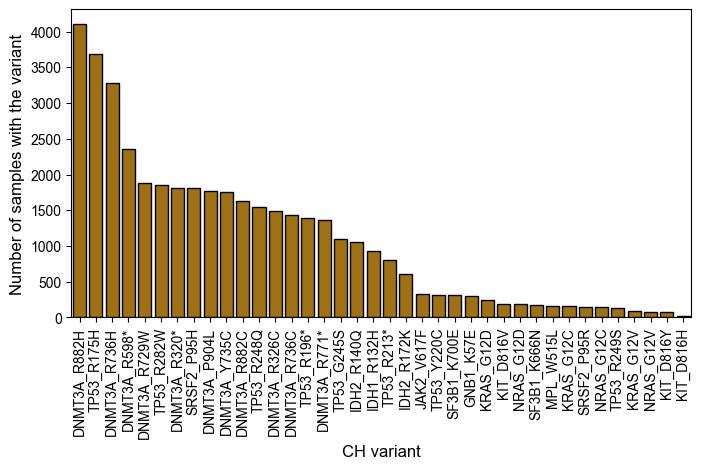

<Figure size 800x400 with 0 Axes>

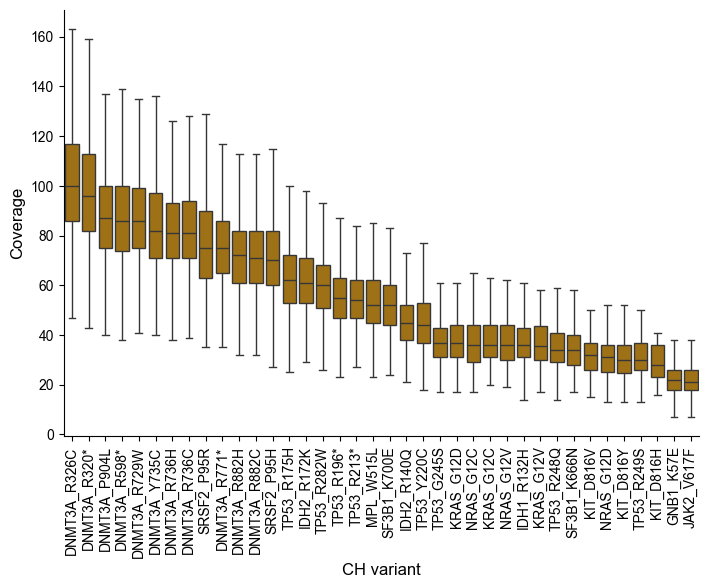

<Figure size 800x400 with 0 Axes>

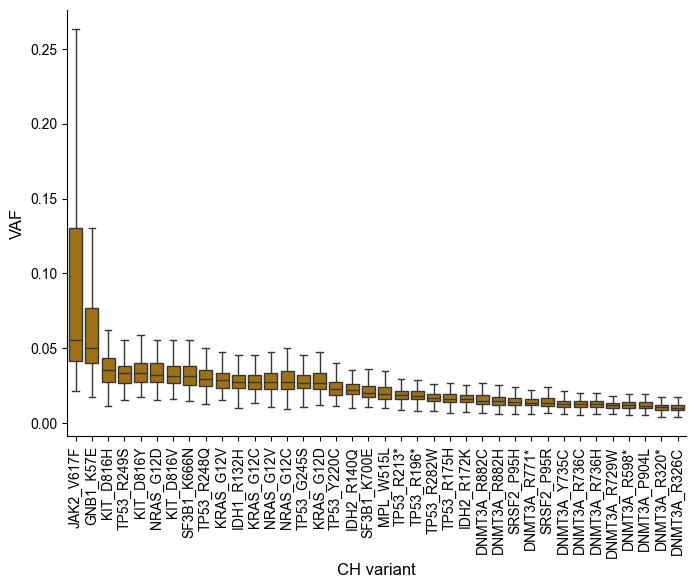

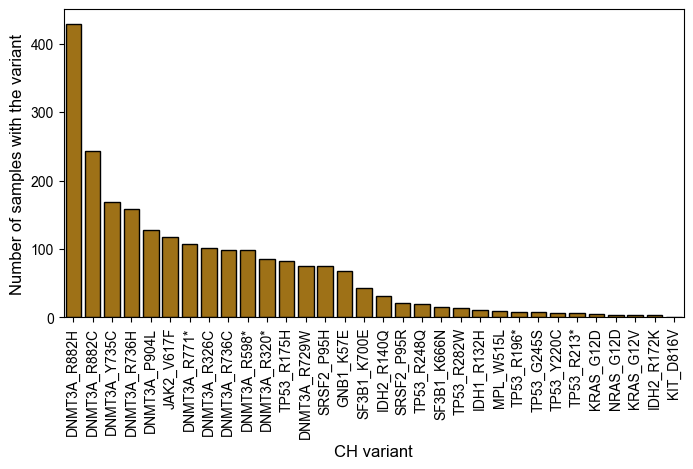

<Figure size 800x400 with 0 Axes>

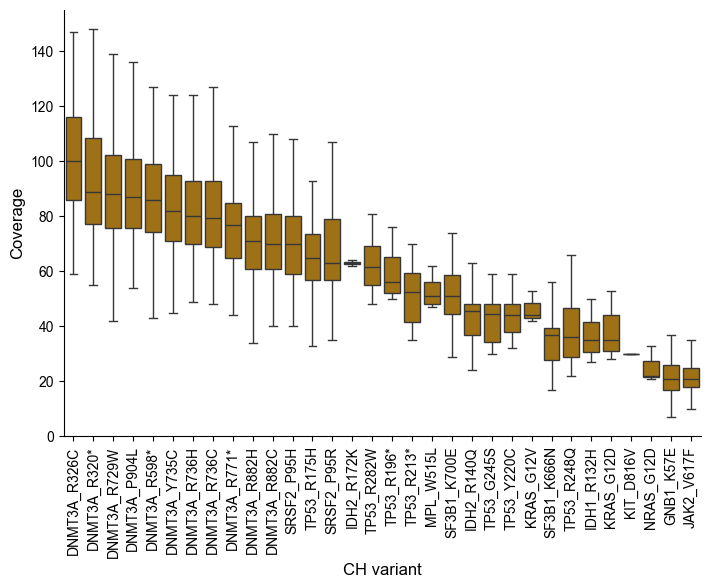

<Figure size 800x400 with 0 Axes>

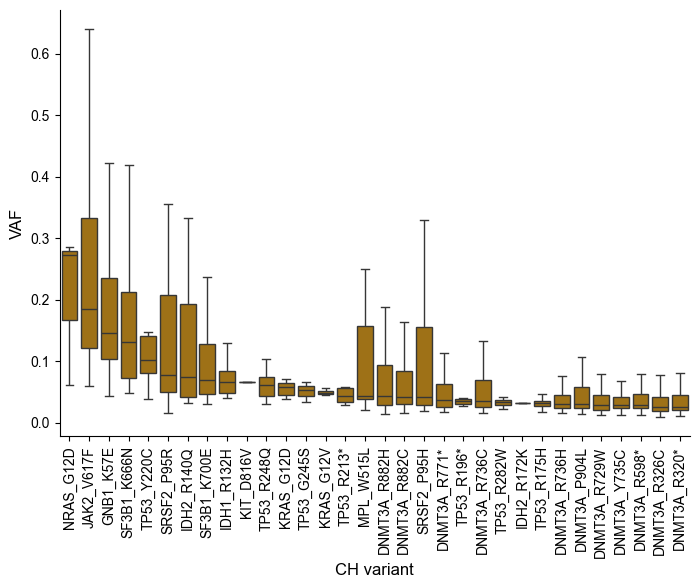

In [75]:

# Plotting 
plot_barplot(gene_vars_sorted, 'gene_var', 'count', color_hist, 'CH variant', 'Number of samples with the variant', 'nr_samples_per_var', 'Number of samples with a given CH variant')
plot_catplot(batch_gene_vars, 'gene_var', 'depth', color_hist, 'CH variant', 'Coverage', 'total_depth_each_var', 'Distirbution of coverage across CH variants')
plot_catplot(batch_gene_vars, 'gene_var', 'VAF', color_hist, 'CH variant', 'VAF', 'vaf', 'Distribution of variant allele frequencies across CH variants')

# NOTE: 
# from plot 1, the top genes differ from top genes at higher frequencies: this may be because these variants are less fit / sites mutate less
# and so the variants do not reach as high frequencies 
# or there could be more errors in these somehow?

# Plotting
# for ns data only (ie Nr reads >= 2)
plot_barplot(gene_vars_sorted_ns, 'gene_var', 'count', color_hist, 'CH variant', 'Number of samples with the variant', 'nr_samples_per_var_ns', 'Number of samples with a given CH variant')
plot_catplot(batch_gene_vars_ns, 'gene_var', 'depth', color_hist, 'CH variant', 'Coverage', 'total_depth_each_var_ns', 'Distirbution of coverage across CH variants')
plot_catplot(batch_gene_vars_ns, 'gene_var', 'VAF', color_hist, 'CH variant', 'VAF', 'vaf_ns', 'Distribution of variant allele frequencies across CH variants')


### Distribution of singletons

In [43]:

# number of singletons
batch_singletons = batch_gene_vars[batch_gene_vars['var_depth'] == 1] 
single_gene_vars = pd.DataFrame(batch_singletons['gene_var'].value_counts())
single_gene_vars['gene_var'] = single_gene_vars.index
single_gene_vars = single_gene_vars.reset_index(drop=True)
single_gene_vars = single_gene_vars.sort_values(by = 'count', ascending=False)

# get singletones as % total for each variant
single_gene_vars = single_gene_vars.rename(columns={'count': 'singletons'})
vars_counts = pd.merge(single_gene_vars, gene_vars_count, on = 'gene_var')
vars_counts['percent_singletons'] = vars_counts['singletons'] / vars_counts['count'] * 100
vars_counts = vars_counts.sort_values(by = 'percent_singletons', ascending=False)

print('Number of identified samples with singletons:', batch_singletons.shape[0])
print('Singletons constitute from', int(min(vars_counts['percent_singletons'].tolist())), 'to', int(max(vars_counts['percent_singletons'].tolist())), 'percent of the sample')

Number of identified samples with singletons: 38503
Singletons constitute from 64 to 100 percent of the sample


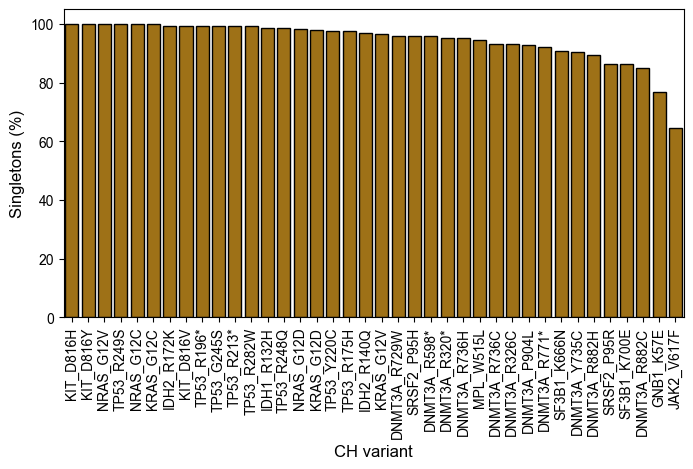

In [60]:

# For each variant, plot the % of reads constituted by singletons
plot_barplot(vars_counts, 'gene_var', 'percent_singletons', color_hist, 'CH variant', 'Singletons (%)', 'percent_singletons_per_var', 'Percentage of singletons across CH variants')

Number of identified samples with singletons: 1129
Doubletons constitute from 14 to 100 percent of the sample


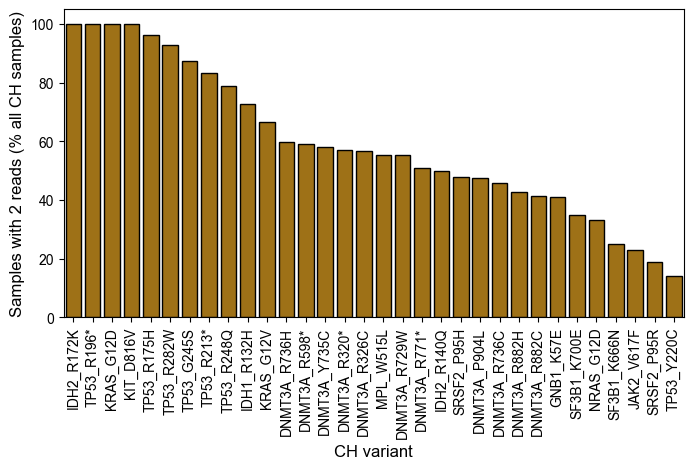

In [62]:

# number of doubletons
batch_doubletons = batch_gene_vars_ns[batch_gene_vars_ns['var_depth'] == 2] 
double_gene_vars = pd.DataFrame(batch_doubletons['gene_var'].value_counts())
double_gene_vars['gene_var'] = double_gene_vars.index
double_gene_vars = double_gene_vars.reset_index(drop=True)
double_gene_vars = double_gene_vars.sort_values(by = 'count', ascending=False)

# get singletones as % total for each variant
double_gene_vars = double_gene_vars.rename(columns={'count': 'doubletons'})
vars_counts_2 = pd.merge(double_gene_vars, gene_vars_count_ns, on = 'gene_var')
vars_counts_2['percent_doubletons'] = vars_counts_2['doubletons'] / vars_counts_2['count'] * 100
vars_counts_2 = vars_counts_2.sort_values(by = 'percent_doubletons', ascending=False)

print('Number of identified samples with singletons:', batch_doubletons.shape[0])
print('Doubletons constitute from', int(min(vars_counts_2['percent_doubletons'].tolist())), 'to', int(max(vars_counts_2['percent_doubletons'].tolist())), 'percent of the sample')

# For each variant, plot the % of reads constituted by singletons
plot_barplot(vars_counts_2, 'gene_var', 'percent_doubletons', color_hist, 'CH variant', 'Samples with 2 reads (% all CH samples)', 'percent_doubletons_per_var', 'Percentage of doubletons across CH variants')


In [46]:
print('Mean VAF (n >= 2):', batch_gene_vars_ns['VAF'].mean())
print('Median VAF (n >= 2):', batch_gene_vars_ns['VAF'].median())

print('Mean coverage (n >= 2):', batch_gene_vars_ns['depth'].mean())
print('Median coverage (n >= 2):', batch_gene_vars_ns['depth'].median())

print('Mean nr of variant reads (n >= 2):', batch_gene_vars_ns['var_depth'].mean())
print('Median nr of variant reads (n >= 2):', batch_gene_vars_ns['var_depth'].median())

Mean VAF (n >= 2): 0.08173884823726048
Median VAF (n >= 2): 0.0384615384615384
Mean coverage (n >= 2): 72.50778123610493
Median coverage (n >= 2): 73.0
Mean nr of variant reads (n >= 2): 4.686971987550022
Median nr of variant reads (n >= 2): 2.0


## Cumulative probability plots

In [47]:

# identify CH hotspot variants
variants = gene_vars['gene_var'].tolist()  

 # split between 1 and >=2 reads, I guess 2 reads is quite confident with higher prior
batch_gene_vars['num_reads'] = np.where(batch_gene_vars['var_depth'] == 1, '1', '>= 2')

# identify numbers of batches that were examined for variants 
batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)

# identify all dataframes with IDs of people examined for variants 

# names of all dataframes with IDs 
all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]

# initialize an empty list 
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:
        
        selected_ids.append(globals()[df_name])

# concat together 
ids_examined = pd.concat(selected_ids, ignore_index=True)

N = ids_examined.shape[0]
print('Number of samples examined for variants:', N)


Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597


In [49]:

# plot VAF distribution for each variant 

# specify colors
colors = [blue4, red4]

# do not show plots  
%matplotlib inline 

# identify variants which were looked for but not identified in the dataset 
missing_variants = []

# plot 
for var in variants:
    df = batch_gene_vars[batch_gene_vars["gene_var"] == f'{var}']
    df = df[['sample_ID', 'depth', 'var_depth', 'VAF', 'gene_var', 'num_reads']]

    # if the dataframe is empty, do not plot but identify the missing variant  
    if df.shape[0] == 0:
        missing_variants.append(var)

    # if variant has been identified, plot cumulative probability 
    else:
        df = df.sort_values(by='VAF')
        df['VAF_percent'] = df['VAF'] * 100

        df['index'] = df['VAF_percent'].rank(ascending=False)
        df['fraction'] = df.apply(lambda row: row['index'] / N, axis=1)

        var_name = var.replace('_', ' ')
        # split into groups of equal size 
        plt.figure(figsize=(3,3)) # set figure size
        sns.scatterplot(data = df, y=f'fraction', x='VAF_percent', hue = 'num_reads', edgecolor='none', alpha=0.5, palette = colors, s = 12)
        # p = sns.lineplot(data = r882h_data, y=f'fraction', x='VAF_percent', hue = 'dataset')

        plt.title(f'{var_name}')
        plt.xlabel(f'VAF (%)')
        plt.ylabel(f'Cumulative probability')
        
        plt.yscale('log')
        plt.ylim(None, 1)

        plt.legend(title = 'Number of reads', loc = 'upper right')

        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/{timestr}_cumulative_vaf_with_var_{var_name}.pdf', bbox_inches='tight')
        plt.close()

In [50]:

# list of sample IDs examined for variants 
ids_examined_list = ids_examined['sample_ID'].tolist()

# list of sample IDs in whom variants were identified 
ids_ch = batch_all['sample_ID'].tolist()

# to make it very clear:
print('Number of people examined for variants:', len(set(ids_examined_list)))
print('Number of people in whom variants were identified:', len(set(ids_ch)))
print('Number of samples in which variants identified:', len(ids_ch))
print('Note: a single person may carry more than one variant')


Number of people examined for variants: 99597
Number of people in whom variants were identified: 52356
Number of samples in which variants identified: 76718
Note: a single person may carry more than one variant


## Distribution of alleles in the UKBB data

### Import MHC class I genotyping data

In [89]:

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df.columns = head 

# subset data for HLA-I and HLA-II class alleles 
# we are only interested in HLA-I for the momnet 
df_hla1 = df.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df.filter(regex='^(Person_|D)') # 488377 cases 

# change 0.5 to 0 to be clear on what alleles you are typing
df_hla1.replace(0.5, 0, inplace=True)
df_hla1.replace(1.5, 1, inplace=True)

# rename the column to sample name to match the batch_gene_vars dataframe
df_hla1 = df_hla1.rename(columns={'Person_ID': 'sample_ID'})

df_clean_hla1 = df_hla1[~df_hla1.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla1 = df_clean_hla1[~df_clean_hla1.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype

print("Number of samples with MHC genotype in the UKBB:", df_hla1.shape[0])
print("Number of samples with high-confidence MHC genotype in the UKBB:", df_clean_hla1.shape[0])


Number of samples with MHC genotype in the UKBB: 488377
Number of samples with high-confidence MHC genotype in the UKBB: 488377


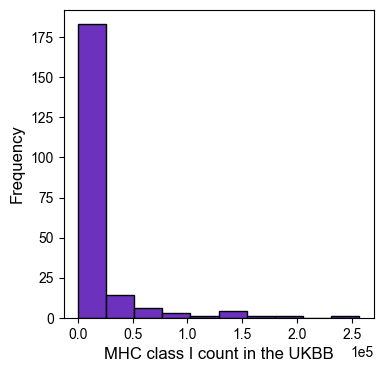

In [105]:

# MHC class I alleles distribution
columns_to_sum = df_hla1.filter(regex='\d').columns
sum_values = df_hla1[columns_to_sum].sum(axis=0) # sum values in each column
result_df = pd.DataFrame({'Sum': sum_values}) # create new df

plt.figure(figsize = (4,4))
plt.hist(result_df['Sum'], edgecolor='black', color = purple0)

# Adding labels and title
plt.xlabel('MHC class I count in the UKBB', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/{timestr}_histogram_MHC_allele_frequencies_in_UKBB_all_cases.pdf', bbox_inches='tight')

# conclusion: most alleles are rare but there are some alleles that are extremely common

In [110]:

# define a function to plot the distribution of the number of typed alleles 

def plot_MHC_typing(low, up, df, color, edgecolor, name):
    
    plt.figure(figsize = (4,4))
    plt.bar(range(low, up), df, width=1, align='center', color=color, edgecolor=edgecolor)

    plt.ylabel('Frequency', fontsize = 12)
    plt.xlabel('Number of typed MHC I alleles', fontsize = 12)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xticks(range(low, up))
    plt.xlim(0,up)
    plt.ylim(0, 5*10**5)

    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    # plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/{timestr}_histogram_MHC_allele_typing_in_UKBB_{name}.pdf', bbox_inches='tight')

In [92]:

## alleles correctly typed in EVERYONE in the UKBB (regardless of if they have CH or not)

df_hla1['typed_hla'] = df_hla1.iloc[:,1:].sum(axis=1)
hla_4_typed_all = (df_hla1['typed_hla'] == 4).sum() # 7
hla_5_typed_all = (df_hla1['typed_hla'] == 5).sum() # 71
hla_6_typed_all = (df_hla1['typed_hla'] == 6).sum() # 898
sum_typed_hla_all = df_hla1['typed_hla'].to_list()
counts_all = [sum_typed_hla_all.count(value) for value in range(1, 7)]

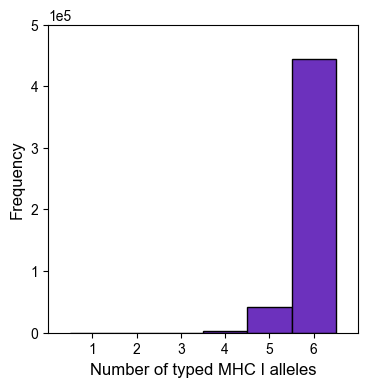

In [111]:
## plot
plot_MHC_typing(1, 7, counts_all, purple0, 'black', 'MHC_typed_cases_UKBB_all')

In [95]:
# add MHC genotype data to CH cases (with annotated variants and scores)
batch_gene_hla = pd.merge(batch_gene_vars, df_hla1, on = 'sample_ID') 
print('Number of CH samples for which MHC genotype is available:', batch_gene_hla.shape[0])

Number of CH samples for which MHC genotype is available: 40704


In [96]:

# all alleles typed (NOTE that this will also include alleles for which you do not have scores from NetMHCpan / PRIME etc)
# here, I am looking only at people who would be considered CH cases (CH variant identified in sequencing data)

batch_gene_hla['typed_hla'] = batch_gene_hla.iloc[:,17:231].sum(axis=1)
hla_4_typed_ch = (batch_gene_hla['typed_hla'] == 4).sum() # 7
hla_5_typed_ch = (batch_gene_hla['typed_hla'] == 5).sum() # 71
hla_6_typed_ch = (batch_gene_hla['typed_hla'] == 6).sum() # 898

sum_typed_hla_ch = batch_gene_hla['typed_hla'].to_list()
counts_ch = [sum_typed_hla_ch.count(value) for value in range(1, 7)]


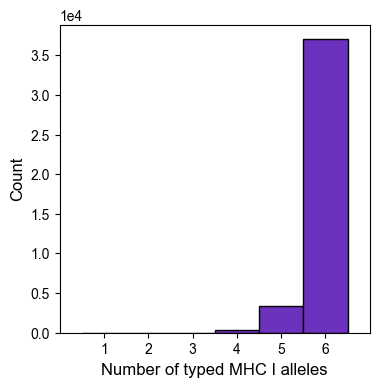

In [97]:
# number of typed alleles with available predictions 
plot_MHC_typing(1, 7, counts_ch, purple0, 'black', 'MHC_typed_cases_UKBB_CH')


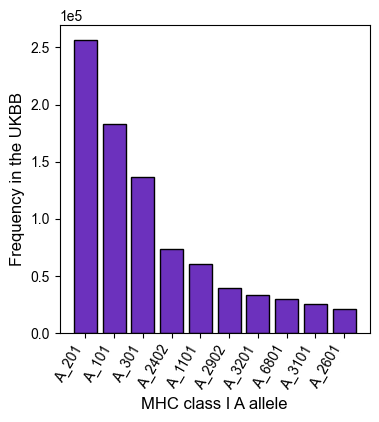

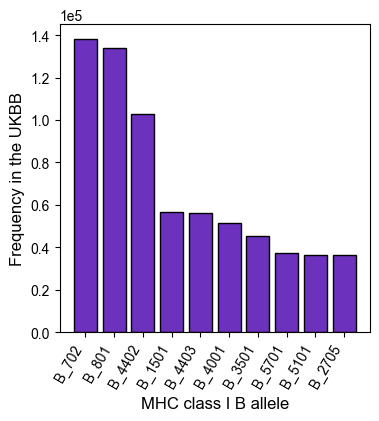

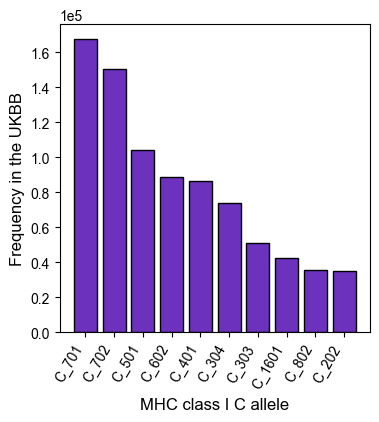

In [101]:

# find top 10 A, B, C alleles by total number of typed alleles 

result_df_reset = result_df.reset_index()
result_df_sorted = result_df_reset.sort_values(by=['index', 'Sum'])
result_df_sorted['cat'] = result_df_sorted['index'].str.split('_').str.get(0)

# Get the top 10 HLA A, B, C by the total number of these alleles typed 
top_names = result_df_sorted.sort_values(by=['cat', 'Sum'], ascending = False)
top_10_entries = top_names.groupby('cat').head(10)
top_10_entries['percent'] = top_10_entries['Sum'] / df_hla1.shape[0] * 100

categories = ['A', 'B', 'C']
for cat in categories:
    df = top_10_entries[top_10_entries['cat'] == cat]
    plt.figure(figsize=(4, 4))
    plt.bar(df['index'], df['Sum'], color = purple0, edgecolor = 'black')
    plt.xlabel(f'MHC class I {cat} allele', fontsize = 12)
    plt.ylabel('Frequency in the UKBB', fontsize = 12)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xticks(rotation=60, ha='right', fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/{timestr}_barchart_MHC_allele_top10_in_UKBB_{cat}.pdf', bbox_inches='tight')


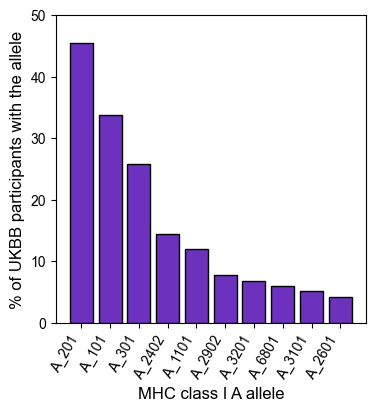

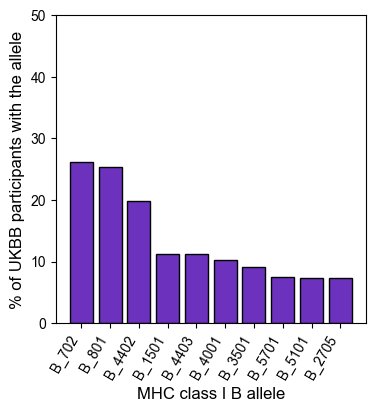

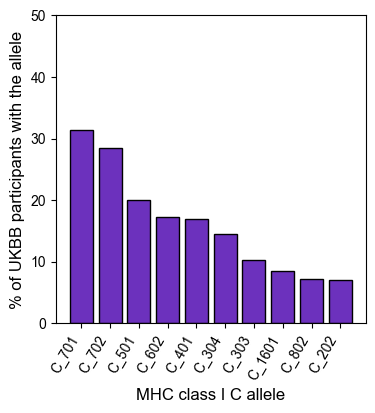

In [104]:

# find top 10 A, B, C alleles by the number of people they are present in (not the total allele count = note that each allele can be present in two copies)
# so the total nr of copies of allele X in the population vs number of people who carry allele X are not the same thing

columns_to_sum = df_hla1.filter(regex='\d').columns
count_values = (df_hla1[columns_to_sum] != 0).sum(axis=0) # sum values in each column
count_mhc_df = pd.DataFrame({'Count': count_values}) # create new df

count_mhc_df_reset = count_mhc_df.reset_index()
count_mhc_df_sorted = count_mhc_df_reset.sort_values(by=['index', 'Count'])
count_mhc_df_sorted['cat'] = count_mhc_df_sorted['index'].str.split('_').str.get(0)

# Get the top 10 names in each category
top_names_count = count_mhc_df_sorted.sort_values(by=['cat', 'Count'], ascending = False)
top_10_entries_count = top_names_count.groupby('cat').head(10)
top_10_entries_count['percent'] = top_10_entries_count['Count'] / df_hla1.shape[0] * 100

categories = ['A', 'B', 'C']
for cat in categories:
    df = top_10_entries_count[top_10_entries_count['cat'] == cat]
    plt.figure(figsize=(4, 4))
    plt.bar(df['index'], df['percent'], color = purple0, edgecolor = 'black')
    plt.xlabel(f'MHC class I {cat} allele', fontsize = 12)
    plt.ylabel('% of UKBB participants with the allele', fontsize = 12)    
    plt.xticks(rotation=60, ha='right', fontsize = 10)
    plt.ylim(0, 50)
    plt.yticks(fontsize = 10)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/{timestr}_barchart_MHC_allele_top10_in_UKBB_{cat}_fraction.pdf', bbox_inches='tight')


# Distribution of NetMHC and PRIME scores in the UKBB data

In [112]:

# need to change format of HLA allele name to align with HLA genotyping file

import re

# transform format (from NetMHCpan data to UKBB format)
def transform_format_netmhc(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w\S*)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from NetMHCpan data to UKBB format) - VERY annoyingly running the same pipeline I can get different formats of HLA allele names
def transform_format_netmhc_2(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from PRIME format to UKBB format)
def transform_format_prime(input_string):
    # regular expression pattern to match the input format
    # Nb PRIME is almost the same as NetMHC but there is no star after "HLA-A*"
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

In [113]:

# Import PRIME and NetMHC data 

pred_file_net = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240210_NetMHC_HLA_UKBB_with_affinities_bestscores.csv' # EL scores, BA scores, EL rank, BA rank, affinity prediction
pred_file_net2 = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240221_percent_ranks_for_each_variant_by_HLA.csv' # EL rank, sum of weakly binding peptides, sum of strongly binding peptides
pred_file_prime = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/PRIME_out/scores/20240220_percent_ranks_for_each_variant_by_HLA.csv' # prediction file for PRIME

pred_filename_net = pred_file_net.split('/')[2].split('.')[0]
pred_filename_net2 = pred_file_net2.split('/')[2].split('.')[0]
pred_method_net = pred_file_net.split('_out')[0]
pred_filename_prime = pred_file_prime.split('/')[2].split('.')[0]
pred_method_prime = pred_file_prime.split('_out')[0]

# Organize NetMHC scores 
netmhc = pd.read_csv(pred_file_net)
netmhc2 = pd.read_csv(pred_file_net2)

# in the original file, I am using "STOP" to indicate stop codons
# I need to change it to "*" to ensure consistent names for variants 
netmhc2['variant'] = netmhc2['variant'].str.replace('STOP', '*')

# rename collumns in NetMHC
netmhc = netmhc.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'allele': 'HLA'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'min_rank': '%Rank_EL_2'}) # rename affinity column 

# uniform HLA allele naming format
NET_col = netmhc.HLA
NET_formatted = NET_col.apply(transform_format_netmhc)
netmhc = pd.concat([netmhc, NET_formatted.rename('HLA_formatted')], axis = 1)
NET_col2 = netmhc2.HLA
NET_formatted2 = NET_col2.apply(transform_format_netmhc_2)
netmhc2 = pd.concat([netmhc2, NET_formatted2.rename('HLA_formatted')], axis = 1)

# select required columns
netmhc = netmhc[['HLA_formatted', 'Peptide', '%Rank_EL', 'Score_EL', '%Rank_BA', 'Score_BA', 'Aff_nM', 'gene', 'variant', 'genotype']]
netmhc2 = netmhc2[['HLA_formatted', '%Rank_EL_2', 'sum_peptides_below_05', 'sum_peptides_below_2', 'gene', 'variant', 'genotype']]

# sort both dataframes so that is easier to compare values
netmhc = netmhc.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])
netmhc2 = netmhc2.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])

# merge two dataframes for netmhc
netmhc_all = pd.merge(netmhc, netmhc2, on = ['HLA_formatted', 'gene', 'variant', 'genotype'])

netmhc_all['gene_var_gt'] = netmhc_all['gene'] + '_' + netmhc_all['variant'] + '_' + netmhc_all['genotype'] # add complete genotype data
netmhc_all['gene_var'] = netmhc_all['gene'] + '_' + netmhc_all['variant']
netmhc_all = netmhc_all.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
scores_netmhc = netmhc_all[['HLA_formatted', 'Score_EL', '%Rank_EL', 'Score_BA', '%Rank_BA', 'Aff_nM', 'gene_var', 'gene_var_gt']] # select columns of interest


In [114]:
# load PRIME data

# Organize PRIME scores 
prime = pd.read_csv(pred_file_prime)
# variants with stop codons are indicated with AposSTOP 
# this is because I couldn't write anything with * (did not accept * in path)
prime['variant'] = prime['variant'].str.replace('STOP', '*')
prime['gene_var_gt'] = prime['gene'] + '_' + prime['variant'] + '_' + prime['genotype'] # add complete genotype data
prime['gene_var'] = prime['gene'] + '_' + prime['variant']
prime = prime.rename(columns={'allele': 'HLA'}) # rename affinity column 
prime = prime.rename(columns={'min_rank': '%Rank_EL'}) # rename affinity column 
scores_prime = prime[['HLA', '%Rank_EL', 'gene', 'variant', 'genotype', 'gene_var_gt']] # select columns of interest

# remove columns with duplicated variants (for stop codons)
stop_to_remove = ['TP53_R213S', 'TP53_R196S', 'DNMT3A_R598S', 'DNMT3A_R771S', 'DNMT3A_R320S']
prime = prime[~prime['gene_var'].isin(stop_to_remove)]

# uniform HLA allele naming format
PRIME_col = prime.HLA
PRIME_formatted = PRIME_col.apply(transform_format_prime)
prime = pd.concat([prime, PRIME_formatted.rename('HLA_formatted')], axis = 1)

# Print the results 
print('Number of alleles for which predictions are available (NetMHC):', len(netmhc_all.HLA_formatted.unique()))
print('Number of unique variants (NetMHC):',  len(netmhc_all.gene_var.unique()))
print('Number of alleles for which predictions are available (PRIME):', len(prime.HLA_formatted.unique()))
print('Number of unique variants (PRIME):',  len(prime.gene_var.unique()))

Number of alleles for which predictions are available (NetMHC): 194
Number of unique variants (NetMHC): 42
Number of alleles for which predictions are available (PRIME): 194
Number of unique variants (PRIME): 42


## Different possible parameters from NetMHC

In [115]:

## correlation between BA scores, BA rank, EL scores, EL rank etc. 
from scipy.stats import pearsonr

def plot_scatter(data, x, y, size=2, color='#32bd6d', alpha=0.5, option=None):
    
    plt.figure(figsize = (4,4))
    
    if option=='log':
        x_values = np.log10(data[x])
        y_values = np.log10(data[y]) 

        # add correlation coefficient 
        correlation_coefficient, _ = pearsonr(data[x], data[y])
        plt.annotate(f'R = {correlation_coefficient:.2f}', xy=(0.95, 0.05), xycoords='axes fraction', fontsize=10, ha='right')

    else:
        x_values = data[x]
        y_values = data[y]
    
    plt.scatter(x_values, y_values, s=size, c=color, alpha=alpha, marker='o')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Correlation between {x} and {y}') 


    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure2/{timestr}/netMHC_scores_corr_{x}_{y}_option.pdf')
    plt.show()

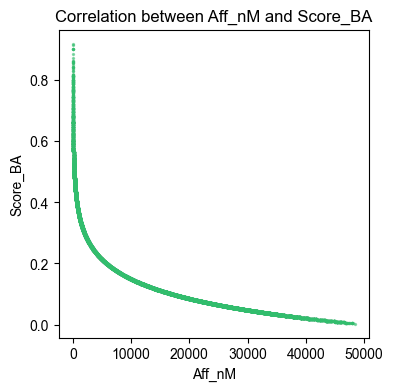

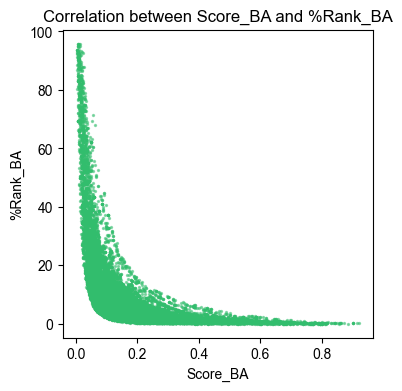

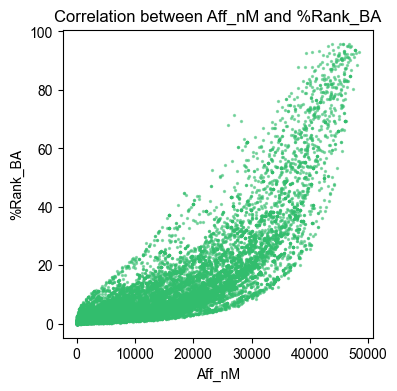

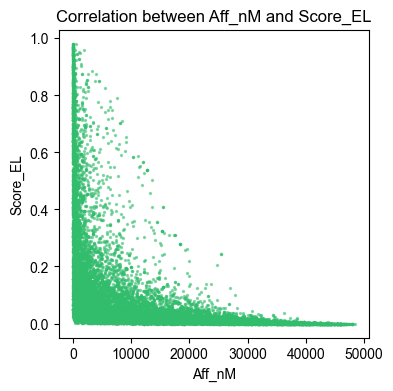

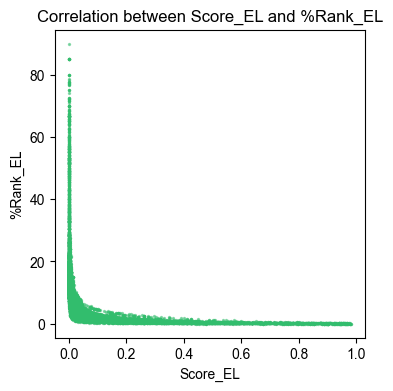

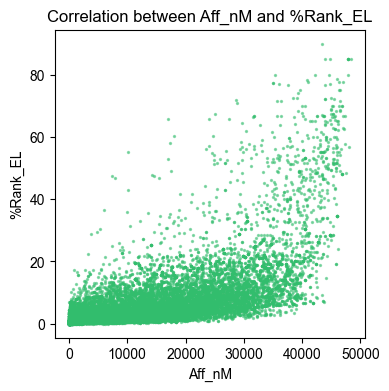

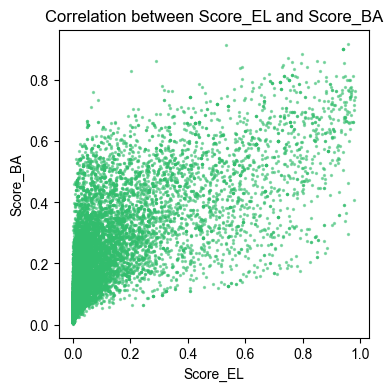

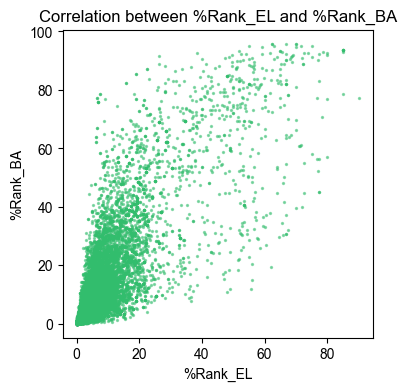

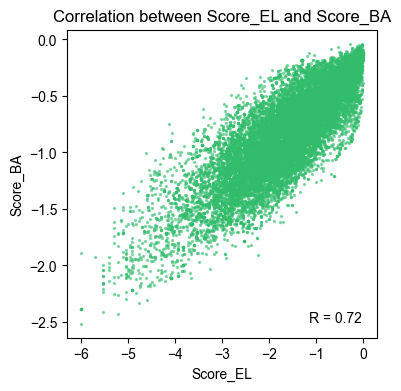

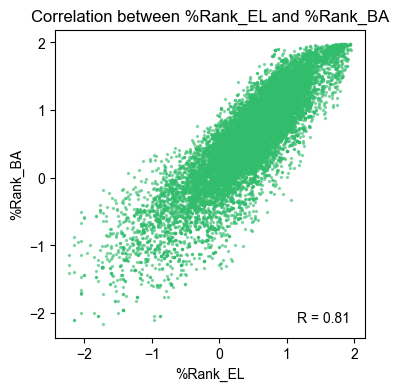

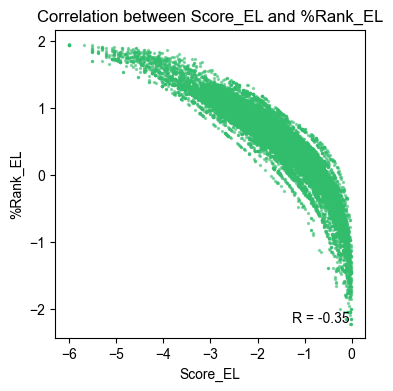

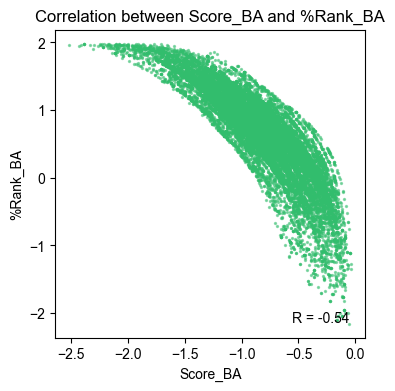

In [116]:

plot_scatter(scores_netmhc, 'Aff_nM', 'Score_BA')
plot_scatter(scores_netmhc, 'Score_BA', '%Rank_BA')
plot_scatter(scores_netmhc, 'Aff_nM', '%Rank_BA')
plot_scatter(scores_netmhc, 'Aff_nM', 'Score_EL')
plot_scatter(scores_netmhc, 'Score_EL', '%Rank_EL')
plot_scatter(scores_netmhc, 'Aff_nM', '%Rank_EL')

# compare BA and EL prediction 
plot_scatter(scores_netmhc, 'Score_EL', 'Score_BA')
plot_scatter(scores_netmhc, '%Rank_EL', '%Rank_BA')
plot_scatter(scores_netmhc, 'Score_EL', 'Score_BA', option = 'log')
plot_scatter(scores_netmhc, '%Rank_EL', '%Rank_BA', option = 'log')
plot_scatter(scores_netmhc, 'Score_EL', '%Rank_EL', option = 'log') # NB correlation is not appropriate here 
plot_scatter(scores_netmhc, 'Score_BA', '%Rank_BA', option = 'log') # NB correlation is not appropriate here 
